In [3]:
# Import stuff in 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines
import random
from datetime import datetime


%matplotlib inline
random.seed(148)

In [151]:
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV

# Helper Functions

In [156]:
#Convert date type/column into datetime object
def convertDateData(column, data):
    data[column] = pd.to_datetime(data[column], format='%m/%Y')
    return data

def convertColumnToFloat(column, data):
    data[column] = pd.to_numeric(data[column])
    return data

def months_between(start_date, end_date):
    num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
    return abs(num_months)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
    
def plotIterLinearRegression(df, brand, pca_flag=False):
    predictions = iterLinearRegression(df, brand, pca_flag)
    
    brandDf = getBrandDataFrame(df, brand)
    
    n = 150
    plt.figure(figsize=(20,20))
    
    plt.plot_date(brandDf['Month'], brandDf['Total Sales ($)'], linestyle='solid', label="Actual")
    plt.plot_date(brandDf.iloc[2:]['Month'], predictions, linestyle='solid', label = 'Prediction')
    plt.legend()
    
    
def iterLinearRegression(df, brand, pca_flag=False):
    #get train / test split for specific brand
    
    brand_df = getBrandDataFrame(df, brand)
    brand_df = brand_df.drop('Brand', axis=1)
    
    predictions = []
    
    for index, row in brand_df.iloc[2:].iterrows():
        X_train, X_test, y_train, y_test = createTrainTestSplit(brand_df, row['Month'])
        
        
        X_train = convertDateColumnToOrdinal('Month', X_train)
        X_train = convertDateColumnToOrdinal('date_first_on_market', X_train)

        X_test = convertDateColumnToOrdinal('Month', X_test)
        X_test = convertDateColumnToOrdinal('date_first_on_market', X_test)
        
        #standardize data
        pipe = Pipeline([('scaler', StandardScaler())])
        X_train = pipe.fit_transform(X_train)
        X_test = pipe.fit_transform(X_test)
        
        
        if pca_flag:
            pca = PCA(0.9)

            pca.fit(X_train)

            X_train = pca.transform(X_train)
            X_test = pca.transform (X_test)

#             print("Number of principal components: ", pca.n_components_)
#             pca.explained_variance_ratio_
            
        model = lin.fit(X_train, y_train)
        test_prediction = model.predict(X_test)
        predictions.append(test_prediction[0])
        
    
    return predictions    

def convertColumnToFloat(column, data):
    data[column] = pd.to_numeric(data[column])
    return data

def convertDateColumnToOrdinal(column, data):
    data[column] = pd.to_numeric(data[column])
    return data



def createTrainTestSplit(df, date_to_predict):
    """
    This function creates our train_test_split, specific to time series data, it will return:
    X_train : all features through the date to predict
    X_test : input features to the model we want to guess., in the months after date_to_predict 
    y_train : sales through the date to predict (2018->date_to_predict)
    y_test : actual sales in and after the date we are predicting (months after date_to_predict)
    """
    
             
    train = df.loc[(df['Month'] < date_to_predict)]
    train = train.sort_values(["Month"]).reset_index(drop=True)
    test = df.loc[(df['Month'] >= date_to_predict)].reset_index(drop=True)
    test = test.sort_values(["Month"]).reset_index(drop=True)


    
    X_train = train.drop('Total Sales ($)', axis=1)
    y_train = train['Total Sales ($)']

    X_test = test.drop('Total Sales ($)', axis=1)
    y_test = test['Total Sales ($)']
    
    return X_train, X_test, y_train, y_test


def getBrandDataFrame(df, brand):
    return df.loc[df['Brand'] == brand]



# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Load Data

In [6]:
brand_details = pd.read_csv('data/BrandDetails.csv')
brand_details = brand_details.sample(frac=1).reset_index(drop=True)

brand_total_sales_data = pd.read_csv('data/BrandTotalSales.csv')
brand_total_sales_data = brand_total_sales_data.sample(frac=1).reset_index(drop=True)

brand_arp_data = pd.read_csv('data/BrandAverageRetailPrice.csv')
brand_arp_data = brand_arp_data.sample(frac=1).reset_index(drop=True)

brand_total_units_data = pd.read_csv('data/BrandTotalUnits.csv')
brand_total_units_data = brand_total_units_data.sample(frac=1).reset_index(drop=True)

In [7]:
brand_details.head()

,State,Channel,Category L1,Category L2,Category L3,Category L4,Category L5,Brand,Product Description,Total Sales ($),...,Total THC,Total CBD,Contains CBD,Pax Filter,Strain,Is Flavored,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,California,Licensed,Inhaleables,Concentrates,Dabbable Concentrates,Caviar,NaN,Concentrate,Concentrate - Berry White - Caviar,"6,383.9201300000000",...,0,0,THC Only,NaN,NaN,NaN,Not Mood Specific,Generic Vendors,Non-Generic Items,$10.00 to $14.99
1,California,Licensed,Inhaleables,Concentrates,Vape,Vape Cartridge,Live Resin Cartridge,Almora Farm,Almora Farm - PAX Era - Vanilla Sherbert - Liv...,251.565745,...,0,0,THC Only,Pax,Vanilla Sherbert,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$35.00 to $39.99
2,California,Licensed,Inhaleables,Concentrates,Vape,Vape Cartridge,Live Resin Cartridge,Raw Garden,Raw Garden - Pink Lemonade - Live Resin Cartri...,"2,286.6198840000000",...,0,0,THC Only,Not Pax,Pink Lemonade,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$35.00 to $39.99
3,California,Licensed,Inhaleables,Pre-Rolled,Infused Pre-Rolled,NaN,NaN,Rollers Delight,Rollers Delight - Triangle Kush - Infused Pre-...,"7,273.080068",...,0,0,THC Only,NaN,Triangle Kush,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
4,California,Licensed,Inhaleables,Concentrates,Vape,Vape Cartridge,Distillate Cartridge,Big Chief,"Big Chief - Blue Dream - Distillate Cartridge,...","466,398.130134",...,0,0,THC Only,Not Pax,Blue Dream,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99


## Remove california field
#### We can see that all state fields are "California" so we can probably drop this

In [8]:
not_california = brand_details[~brand_details["State"].isin(["California"])]
not_california.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   State                0 non-null      object 
 1   Channel              0 non-null      object 
 2   Category L1          0 non-null      object 
 3   Category L2          0 non-null      object 
 4   Category L3          0 non-null      object 
 5   Category L4          0 non-null      object 
 6   Category L5          0 non-null      object 
 7   Brand                0 non-null      object 
 8   Product Description  0 non-null      object 
 9   Total Sales ($)      0 non-null      object 
 10  Total Units          0 non-null      object 
 11  ARP                  0 non-null      float64
 12  Flavor               0 non-null      object 
 13  Items Per Pack       0 non-null      int64  
 14  Item Weight          0 non-null      object 
 15  Total THC            0 non-null      object 
 16  To

In [9]:
brand_details = brand_details.drop("State", axis=1)
brand_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144977 entries, 0 to 144976
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Channel              144977 non-null  object 
 1   Category L1          144977 non-null  object 
 2   Category L2          144977 non-null  object 
 3   Category L3          144245 non-null  object 
 4   Category L4          102618 non-null  object 
 5   Category L5          50135 non-null   object 
 6   Brand                144977 non-null  object 
 7   Product Description  144977 non-null  object 
 8   Total Sales ($)      144977 non-null  object 
 9   Total Units          144977 non-null  object 
 10  ARP                  144977 non-null  float64
 11  Flavor               7807 non-null    object 
 12  Items Per Pack       144977 non-null  int64  
 13  Item Weight          64454 non-null   object 
 14  Total THC            144977 non-null  object 
 15  Total CBD        

## Reorder brand_details
#### In order to have brand in first column,making it easier for us to read

In [10]:
column_reordering = ["Brand", "Product Description", "Category L1", "Category L2", "Category L3", "Category L4", "Category L5", "Total Sales ($)", "Total Units", "ARP", "Channel", "Flavor", "Items Per Pack", "Item Weight", "Total THC", "Total CBD", "Contains CBD", "Pax Filter", "Strain", "Is Flavored", "Mood Effect", "Generic Vendor", "Generic Items", "$5 Price Increment"]
brand_details = brand_details.reindex(columns=column_reordering)
brand_details = brand_details.sort_values(by=['Brand'], ascending = True)
brand_details = brand_details.reset_index(drop = True)
brand_details.head()

,Brand,Product Description,Category L1,Category L2,Category L3,Category L4,Category L5,Total Sales ($),Total Units,ARP,...,Total THC,Total CBD,Contains CBD,Pax Filter,Strain,Is Flavored,Mood Effect,Generic Vendor,Generic Items,$5 Price Increment
0,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),Inhaleables,Flower,Hybrid,NaN,NaN,"1,103.964857",85.86394100000000,12.857142,...,0,0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
1,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),Inhaleables,Flower,Sativa Dominant,NaN,NaN,"14,589.916417","1,195.9888350000000",12.199041,...,0,0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$10.00 to $14.99
2,#BlackSeries,#BlackSeries - Blueberry Slushy - Flower (Gram),Inhaleables,Flower,Sativa Dominant,NaN,NaN,"2,473.699102",157.417226,15.714285,...,0,0,THC Only,NaN,Blueberry Slushy,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
3,#BlackSeries,#BlackSeries - Vanilla Frosting - Flower (Gram),Inhaleables,Flower,Hybrid,NaN,NaN,674.645211,42.931971000000000,15.714285,...,0,0,THC Only,NaN,Vanilla Frosting,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$15.00 to $19.99
4,101 Cannabis Co.,101 Cannabis Co. - Durban Poison - Wax,Inhaleables,Concentrates,Dabbable Concentrates,Wax,NaN,"2,121.358598",57.283264,37.032781,...,0,0,THC Only,NaN,Durban Poison,NaN,Not Mood Specific,Non-Generic Vendors,Non-Generic Items,$35.00 to $39.99


## Reorder brand_total_sales_data & Convert Months to datetime

In [11]:
bts_columns = ["Brand", "Months", "Total Sales ($)"]
brand_total_sales_data = brand_total_sales_data.reindex(columns=bts_columns)
brand_total_sales_data = brand_total_sales_data.sort_values(by=["Brand", "Months"], ascending=True)
brand_total_sales_data = brand_total_sales_data.reset_index(drop=True)
brand_total_sales_data.head()

,Brand,Months,Total Sales ($)
0,#BlackSeries,01/2021,"9,739.4234"
1,#BlackSeries,02/2021,"9,102.802187000000"
2,#BlackSeries,08/2020,"25,352.135918000000"
3,101 Cannabis Co.,01/2020,"11,790.663567"
4,101 Cannabis Co.,01/2021,"8,059.176644000000"


#### Convert to datetime

In [12]:
brand_total_sales_data = convertDateData("Months", brand_total_sales_data)
brand_total_sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Brand            25279 non-null  object        
 1   Months           25279 non-null  datetime64[ns]
 2   Total Sales ($)  25279 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 592.6+ KB


## Create new dataframe | Concatination of all csv files

### Initialize with brand_total_sales_data information

In [13]:
# Our new dataframe that will be a merging of all other csv files
df = pd.DataFrame( columns = ['Brand', 'Month',"Total Sales ($)", "ARP", "Total Units"])
df["Brand"] = brand_total_sales_data["Brand"]
df["Month"] = brand_total_sales_data["Months"]
df["Total Sales ($)"] = brand_total_sales_data["Total Sales ($)"]

### Convert brand_arp_data months to datetime

In [14]:
brand_arp_data = convertDateData("Months", brand_arp_data)

### Append arp data to dataframe

In [15]:
appendings = []
for index, row in brand_arp_data.iterrows():
    if index > -1:
        # Column values to match
        local_month = row["Months"]
        local_brand = row["Brands"]

        copy_value = row["ARP"]
        
        # Find matching row in main df dataframe
        matched_row = df[["Brand", "Month", "Total Sales ($)", "ARP", "Total Units"]][(df["Brand"] == local_brand) & (df["Month"] == local_month)]
        
        # if row was found
        if not matched_row.empty:
            matched_index = matched_row.index.tolist()[0]
            appendings.append((matched_index, copy_value))


# append new values
for appending in appendings:
    index = appending[0]
    arp = appending[1]
    df.iat[index, df.columns.get_loc('ARP')] = arp

#### Our updated dataframe

In [16]:
df.head(10)

,Brand,Month,Total Sales ($),ARP,Total Units
0,#BlackSeries,2021-01-01,"9,739.4234",13.611428,NaN
1,#BlackSeries,2021-02-01,"9,102.802187000000",11.873182,NaN
2,#BlackSeries,2020-08-01,"25,352.135918000000",15.684913,NaN
3,101 Cannabis Co.,2020-01-01,"11,790.663567",34.134929,NaN
4,101 Cannabis Co.,2021-01-01,"8,059.176644000000",32.206812,NaN
5,101 Cannabis Co.,2020-02-01,"20,266.761007000000",29.091388,NaN
6,101 Cannabis Co.,2021-02-01,"13,712.773455000000",34.643599,NaN
7,101 Cannabis Co.,2020-03-01,"30,465.470533000000",32.293498,NaN
8,101 Cannabis Co.,2021-03-01,"24,347.90462",35.448267,NaN
9,101 Cannabis Co.,2020-04-01,"23,465.657692000000",32.934344,NaN


### Convert brand_total_units_data months to datetime

In [17]:
brand_total_units_data = convertDateData("Months", brand_total_units_data)

### Append total_units_data to dataframe

#### Find what to append

In [18]:

appendings2 = []
for index, row in brand_total_units_data.iterrows():
    if index > -1:
        local_month = row["Months"]
        local_brand = row["Brands"]
        copy_value = row["Total Units"]
        matched_row = df[["Brand", "Month", "Total Sales ($)", "ARP", "Total Units"]][(df["Brand"] == local_brand) & (df["Month"] == local_month)]
        if not matched_row.empty:
            matched_index = matched_row.index.tolist()[0]
            appendings2.append((matched_index, copy_value))



#### Append to dataframe

In [19]:
for appending in appendings2:
    index = appending[0]
    tu = appending[1].rstrip("0")
    tu = float("".join(tu.split(",")))
    df.iat[index, df.columns.get_loc('Total Units')] = tu

## Convert columns (arp, sales, units) to float

### Convert total units and arp to float type

In [20]:
df = convertColumnToFloat("Total Units", df)
df = convertColumnToFloat("ARP", df)

### Stripe comma and extra unneeded 0's from right

In [21]:
df["Total Sales ($)"] = df["Total Sales ($)"].apply(lambda x: "".join(x.rstrip("0").split(",")))

In [22]:
df.head(20)

,Brand,Month,Total Sales ($),ARP,Total Units
0,#BlackSeries,2021-01-01,9739.4234,13.611428,715.532838
1,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135
2,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004
3,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448
4,101 Cannabis Co.,2021-01-01,8059.176644,32.206812,250.232050
5,101 Cannabis Co.,2020-02-01,20266.761007,29.091388,696.658431
6,101 Cannabis Co.,2021-02-01,13712.773455,34.643599,395.824159
7,101 Cannabis Co.,2020-03-01,30465.470533,32.293498,943.393328
8,101 Cannabis Co.,2021-03-01,24347.90462,35.448267,686.857410
9,101 Cannabis Co.,2020-04-01,23465.657692,32.934344,712.498102


### Remove rows/months where there were no sales
#### We assume that the brand was not sold that month which we ignore and assume all brands will be sold in predicted month

In [23]:

# not sure if I need this df[["Brand","Month", "Total Sales ($)", "ARP", "Total Units"]][(df["Total Sales ($)"] == '')]

df = df[df['Total Sales ($)'] != '']


#### Ensure no sales months exist where the brand was elected to not be sold

In [24]:

df[["Brand","Month", "Total Sales ($)", "ARP", "Total Units"]][(df["Total Sales ($)"] == '')]

,Brand,Month,Total Sales ($),ARP,Total Units


### Convert total sales to float

In [25]:
df["Total Sales ($)"] = df["Total Sales ($)"].apply(lambda x: float(x))

df.info()
# Concatination of the 3 time series files, is done

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25276 entries, 0 to 25278
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Brand            25276 non-null  object        
 1   Month            25276 non-null  datetime64[ns]
 2   Total Sales ($)  25276 non-null  float64       
 3   ARP              25276 non-null  float64       
 4   Total Units      25276 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.2+ MB


In [26]:
#Brainstorming notes
# could come up with some fields like
# offers_concentrates, offers_edibles, offers_prerolls, offers_flower, 
# offers_topicals, offers_edibles, offers_devices
# offers_sublinguals,offers_other_cannabis_products,
# num_of_products

#Time series features
#time series: sales_last_6_months, sales_last_3_months, sales_last_1_month

brand_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144977 entries, 0 to 144976
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Brand                144977 non-null  object 
 1   Product Description  144977 non-null  object 
 2   Category L1          144977 non-null  object 
 3   Category L2          144977 non-null  object 
 4   Category L3          144245 non-null  object 
 5   Category L4          102618 non-null  object 
 6   Category L5          50135 non-null   object 
 7   Total Sales ($)      144977 non-null  object 
 8   Total Units          144977 non-null  object 
 9   ARP                  144977 non-null  float64
 10  Channel              144977 non-null  object 
 11  Flavor               7807 non-null    object 
 12  Items Per Pack       144977 non-null  int64  
 13  Item Weight          64454 non-null   object 
 14  Total THC            144977 non-null  object 
 15  Total CBD        

## Brand features


In [27]:
unique_brands = df["Brand"].unique()

### Dictionary to keep track of what type of product each brand sells

#### Create 2 dictionaries, one to keep track how many products and product type each brand has, and one to keep track of what types of products each brand has 

In [28]:
brand_product_dictionary = {}
brand_product_count_dictionary = {}


#### We are going to first determine which brands sell what kinds of products, and append that data to our dataframe

In [29]:
brand_details["Category L2"].unique()

array(['Flower', 'Concentrates', 'Pre-Rolled', 'Topicals', 'Edibles',
       'Devices', 'Sublinguals', 'Other Cannabis', 'Accessories',
       'Non Infused Food', 'Apparel', 'Grow Supplies', 'Shake/Trim/Lite'],
      dtype=object)

#### Populate dictionaries

In [30]:
product_types = [
    "Flower",
    "Concentrates",
    "Pre-Rolled",
    "Topicals",
    "Edibles",
    "Devices",
    "Sublinguals",
    "Other Cannabis",
    "Accessories",
    "Non Infused Food",
    "Apparel",
    "Grow Supplies",
    "Shake/Trim/Lite"
]

for brand_name in unique_brands:
    brand_result = brand_details[["Brand", "Category L2"]][(brand_details["Brand"] == brand_name)]
    brand_offerings = []
    
    for product_type in product_types:
        if product_type in brand_result["Category L2"].values:
            brand_offerings.append(product_type)
            
    # The kinds of products offered
    brand_product_dictionary[brand_name] = brand_offerings
    # How many kinds, and how many offered total
    brand_product_count_dictionary[brand_name] = [len(brand_offerings), len(brand_result)]

### Initialize new brand level features

In [31]:
# do we want to have all of these initialized to 0's
df["offers_flower"] = 0
df["offers_concentrates"] = 0
df["offers_prerolls"] = 0
df["offers_topicals"] = 0
df["offers_edibles"] = 0
df["offers_devices"] = 0
df["offers_sublinguals"] = 0
df["offers_other_cannabis"] = 0
df["offers_accessories"] = 0
df["offers_noninfused_food"] = 0
df["offers_apparel"] = 0
df["offers_grow_supplies"] = 0
df["offers_shake"] = 0
df["num_products"] = 0
df["num_product_types"] = 0
df["time_in_market"] = 0
df["date_first_on_market"] = datetime(1990, 1,1)

#### A couple of constants used as helpers elsewhere

In [32]:
# df_brand_name = "101 Cannabis Co."
df_return_rows = [
    "Brand",
    "Month",
    "Total Sales ($)",
    "ARP",
    "Total Units",
    "offers_flower", 
    "offers_concentrates", 
    "offers_prerolls", 
    "offers_topicals", 
    "offers_edibles", 
    "offers_devices", 
    "offers_sublinguals", 
    "offers_other_cannabis", 
    "offers_accessories", 
    "offers_noninfused_food", 
    "offers_apparel", 
    "offers_grow_supplies", 
    "offers_shake",
    "num_products",
    "num_product_types",
    "time_in_market",
    "date_first_on_market"
]


product_to_column_map = {
    "Flower": "offers_flower",
    "Concentrates": "offers_concentrates",
    "Pre-Rolled": "offers_prerolls",
    "Topicals": "offers_topicals",
    "Edibles": "offers_edibles",
    "Devices": "offers_devices",
    "Sublinguals": "offers_sublinguals",
    "Other Cannabis": "offers_other_cannabis",
    "Accessories": "offers_accessories",
    "Non Infused Food": "offers_noninfused_food",
    "Apparel": "offers_apparel",
    "Grow Supplies": "offers_grow_supplies",
    "Shake/Trim/Lite": "offers_shake",
}

#### Update our data to correct column information

In [33]:
for df_brand_name in unique_brands:
    
    # All rows for this specific df_brand_name
    df_brand = df[df_return_rows][(df["Brand"] == df_brand_name)]

    # From dictionary
    available_products = brand_product_dictionary[df_brand_name] # ["Concentrates", "Flower"]
    not_offered_by_brand = [x for x in product_types if x not in available_products ]
    offered_by_brand = [x for x in product_types if x in available_products ]
    
    # Set specific product types
    for product in not_offered_by_brand:
        col = product_to_column_map[product]
        df_brand[col] = 0
    for product in offered_by_brand:
        col = product_to_column_map[product]
        df_brand[col] = 1
        
    # Set how many products/types
    df_brand["num_product_types"] = brand_product_count_dictionary[df_brand_name][0]
    df_brand["num_products"] = brand_product_count_dictionary[df_brand_name][1]
    
    # Update main dataframe
    df[(df["Brand"] == df_brand_name)] = df_brand



#### Preview new data fields

In [34]:
# See new data
df.head(20)

,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,...,offers_other_cannabis,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,time_in_market,date_first_on_market
0,#BlackSeries,2021-01-01,9739.423400,13.611428,715.532838,1,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01
1,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135,1,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01
2,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004,1,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01
3,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448,0,1,1,0,0,...,0,0,0,0,0,0,77,2,0,1990-01-01
4,101 Cannabis Co.,2021-01-01,8059.176644,32.206812,250.232050,0,1,1,0,0,...,0,0,0,0,0,0,77,2,0,1990-01-01
5,101 Cannabis Co.,2020-02-01,20266.761007,29.091388,696.658431,0,1,1,0,0,...,0,0,0,0,0,0,77,2,0,1990-01-01
6,101 Cannabis Co.,2021-02-01,13712.773455,34.643599,395.824159,0,1,1,0,0,...,0,0,0,0,0,0,77,2,0,1990-01-01
7,101 Cannabis Co.,2020-03-01,30465.470533,32.293498,943.393328,0,1,1,0,0,...,0,0,0,0,0,0,77,2,0,1990-01-01
8,101 Cannabis Co.,2021-03-01,24347.904620,35.448267,686.857410,0,1,1,0,0,...,0,0,0,0,0,0,77,2,0,1990-01-01
9,101 Cannabis Co.,2020-04-01,23465.657692,32.934344,712.498102,0,1,1,0,0,...,0,0,0,0,0,0,77,2,0,1990-01-01


### Sort each brand by ascending date
#### This is in order to more easily construct time series features

In [35]:
#correct, works easier & better
df_sorted = df.sort_values(["Brand", "Month"]).reset_index(drop=True)

In [36]:
# THINK IT BROKE HERE
# df_sorted.loc[:, "Previous Month Total Units"] = df_sorted.loc[:, "Total Units"].shift(1)
df_sorted

,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,...,offers_other_cannabis,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,time_in_market,date_first_on_market
0,#BlackSeries,2020-08-01,25352.135918,15.684913,1616.339004,1,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01
1,#BlackSeries,2021-01-01,9739.423400,13.611428,715.532838,1,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01
2,#BlackSeries,2021-02-01,9102.802187,11.873182,766.669135,1,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01
3,101 Cannabis Co.,2019-11-01,4465.040321,34.066667,131.067720,0,1,1,0,0,...,0,0,0,0,0,0,77,2,0,1990-01-01
4,101 Cannabis Co.,2020-01-01,11790.663567,34.134929,345.413448,0,1,1,0,0,...,0,0,0,0,0,0,77,2,0,1990-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25271,iKrusher,2020-05-01,10892.946263,10.667051,1021.176952,0,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01
25272,iKrusher,2020-06-01,7218.730212,10.750000,671.509800,0,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01
25273,iKrusher,2021-07-01,7757.371062,19.189128,404.258649,0,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01
25274,iKrusher,2021-08-01,18903.670968,19.144384,987.426417,0,0,0,0,0,...,0,0,0,0,0,0,4,1,0,1990-01-01


In [37]:
#FOR ANTHONY: IGNORE THESE BOTTOM TWO JUST KEEP ADDING ON, WAS THINKING WE MIGHT USE THESE LATER
def countProductTypeByBrand(data, brand, product_type, fields_to_return):
    result = data[fields_to_return][(data["Brand"] == brand)]
    return result.shape[0]

print(countProductTypeByBrand(brand_details, brand_name, "Flower", ["Brand", "Category L2"]))

4


In [38]:
#prev month total sales and prev month arp and 3mo rolling average
df_sorted.loc[:, "Previous Month Total Sales"] = df_sorted.loc[:, "Total Sales ($)"].shift(1)
df_sorted.loc[:, "Previous Month ARP"] = df_sorted.loc[:, "ARP"].shift(1)

## "Time In Market" and "Date First Appeared" Brand features

In [39]:
# Get first month/year that a brand appears

brand_first_occurance_dictionary = {}
brand_last_occurance_dictionary = {}
previous_brand = ""
previous_month = None
for index, row in df_sorted.iterrows():
    local_brand = row["Brand"]
    local_date = row["Month"]
#     print(local_brand, local_date, previous_brand, previous_month)
    if local_brand not in brand_first_occurance_dictionary:
        brand_first_occurance_dictionary[local_brand] = local_date
        if previous_brand != "":
            brand_last_occurance_dictionary[previous_brand] = previous_month
    previous_brand = local_brand
    previous_month = local_date
brand_last_occurance_dictionary[previous_brand] = previous_month

In [40]:
brand_rows = ""

for brand in unique_brands:

    diff_time = brand
    first = brand_first_occurance_dictionary[brand]
    last = brand_last_occurance_dictionary[brand]
    brand_rows = df_sorted[(df_sorted["Brand"] == brand)]
    brand_rows["date_first_on_market"] = first
    brand_rows["time_in_market"] = months_between(first, last)
    df_sorted[(df_sorted["Brand"] == brand)] = brand_rows
brand_rows

<ipython-input-40-676b60762b6d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_rows["date_first_on_market"] = first
<ipython-input-40-676b60762b6d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_rows["time_in_market"] = months_between(first, last)


,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,...,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,time_in_market,date_first_on_market,Previous Month Total Sales,Previous Month ARP
25269,iKrusher,2020-02-01,18890.658835,9.329588,2024.811664,0,0,0,0,0,...,0,0,0,0,4,1,19,2020-02-01,5008.728648,36.850000
25270,iKrusher,2020-03-01,285.179135,6.262846,45.535074,0,0,0,0,0,...,0,0,0,0,4,1,19,2020-02-01,18890.658835,9.329588
25271,iKrusher,2020-05-01,10892.946263,10.667051,1021.176952,0,0,0,0,0,...,0,0,0,0,4,1,19,2020-02-01,285.179135,6.262846
25272,iKrusher,2020-06-01,7218.730212,10.750000,671.509800,0,0,0,0,0,...,0,0,0,0,4,1,19,2020-02-01,10892.946263,10.667051
25273,iKrusher,2021-07-01,7757.371062,19.189128,404.258649,0,0,0,0,0,...,0,0,0,0,4,1,19,2020-02-01,7218.730212,10.750000
25274,iKrusher,2021-08-01,18903.670968,19.144384,987.426417,0,0,0,0,0,...,0,0,0,0,4,1,19,2020-02-01,7757.371062,19.189128
25275,iKrusher,2021-09-01,12953.450473,19.256250,672.688126,0,0,0,0,0,...,0,0,0,0,4,1,19,2020-02-01,18903.670968,19.144384


In [41]:
#remove previous month entries where the values overflowed across companies
#setting the values to 0 if its the first month
df_cleaned = df_sorted
b = ''
for index, row in df_cleaned.iterrows():
    if b != row['Brand']:
        #first month of brand's existence
        #set prev month values to 0
#         df_cleaned.at[index,'Previous Month Total Units'] = 0
        df_cleaned.at[index,'Previous Month Total Sales'] = 0
        df_cleaned.at[index,'Previous Month ARP'] = 0
    b = row['Brand']
    

In [42]:
df_sorted = df_cleaned


In [43]:
# df_sorted.loc[:,'3mo Average Units'] = (df_sorted.loc[:,'Total Units'].shift(1) + df_sorted.loc[:,'Total Units'].shift(2) + df_sorted.loc[:,'Total Units'].shift(3))/3
# df_sorted.loc[:,'3mo Average Sales'] = (df_sorted.loc[:,'Total Sales ($)'].shift(1) + df_sorted.loc[:,'Total Sales ($)'].shift(2) + df_sorted.loc[:,'Total Sales ($)'].shift(3))/3
# df_sorted.loc[:,'3mo Average ARP']   = (df_sorted.loc[:,'ARP'].shift(1) + df_sorted.loc[:,'ARP'].shift(2) + df_sorted.loc[:,'ARP'].shift(3))/3

#JC : the three month averages are easy to compute ^^ however they seem to be causing more problems than theyre solving.
#the data captures the 3 month averages in its current state, we will just need to compute it if /  when we need it

In [44]:
#Reorder columns
cols = ['Brand', 'Month', 'Total Sales ($)', 'Total Units', 'ARP', 'Previous Month Total Sales', 'Previous Month ARP',"date_first_on_market", "time_in_market", 'num_products', 'num_product_types', 'offers_flower', 'offers_concentrates', 'offers_prerolls', 'offers_topicals', 'offers_edibles', 'offers_sublinguals', 'offers_other_cannabis', 'offers_accessories', 'offers_noninfused_food', 'offers_apparel', 'offers_grow_supplies', 'offers_shake']
df_sorted.reindex(columns=cols)

,Brand,Month,Total Sales ($),Total Units,ARP,Previous Month Total Sales,Previous Month ARP,date_first_on_market,time_in_market,num_products,...,offers_prerolls,offers_topicals,offers_edibles,offers_sublinguals,offers_other_cannabis,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake
0,#BlackSeries,2020-08-01,25352.135918,1616.339004,15.684913,0.000000,0.000000,2020-08-01,6,4,...,0,0,0,0,0,0,0,0,0,0
1,#BlackSeries,2021-01-01,9739.423400,715.532838,13.611428,25352.135918,15.684913,2020-08-01,6,4,...,0,0,0,0,0,0,0,0,0,0
2,#BlackSeries,2021-02-01,9102.802187,766.669135,11.873182,9739.423400,13.611428,2020-08-01,6,4,...,0,0,0,0,0,0,0,0,0,0
3,101 Cannabis Co.,2019-11-01,4465.040321,131.067720,34.066667,0.000000,0.000000,2019-11-01,22,77,...,1,0,0,0,0,0,0,0,0,0
4,101 Cannabis Co.,2020-01-01,11790.663567,345.413448,34.134929,4465.040321,34.066667,2019-11-01,22,77,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25271,iKrusher,2020-05-01,10892.946263,1021.176952,10.667051,285.179135,6.262846,2020-02-01,19,4,...,0,0,0,0,0,0,0,0,0,0
25272,iKrusher,2020-06-01,7218.730212,671.509800,10.750000,10892.946263,10.667051,2020-02-01,19,4,...,0,0,0,0,0,0,0,0,0,0
25273,iKrusher,2021-07-01,7757.371062,404.258649,19.189128,7218.730212,10.750000,2020-02-01,19,4,...,0,0,0,0,0,0,0,0,0,0
25274,iKrusher,2021-08-01,18903.670968,987.426417,19.144384,7757.371062,19.189128,2020-02-01,19,4,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#JC: do you know why iKrusher is at the bottom? shouldnt we have zuma?

In [46]:
df = df_sorted

In [47]:
df.describe()

,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,offers_devices,offers_sublinguals,...,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,time_in_market,Previous Month Total Sales,Previous Month ARP
count,2.527600e+04,25276.000000,2.527600e+04,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,...,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,25276.000000,2.527600e+04,25276.000000
mean,4.094214e+05,22.682424,2.886553e+04,0.365287,0.356860,0.336090,0.079483,0.221158,0.125771,0.091747,...,0.028169,0.002928,0.001464,0.001464,0.001464,178.979665,1.662724,26.468547,3.972716e+05,21.343841
std,1.596113e+06,19.802357,1.617249e+05,0.481520,0.479083,0.472379,0.270496,0.415035,0.331598,0.288674,...,0.165459,0.054030,0.038233,0.038233,0.038233,482.397225,1.255772,10.729078,1.575933e+06,19.922400
min,1.105180e-01,0.007437,3.842953e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,1.391597e+04,10.514253,7.173228e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,18.000000,1.096943e+04,9.446243
50%,6.219871e+04,17.035672,3.606163e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,1.000000,31.000000,5.743262e+04,16.022459
75%,2.473617e+05,31.505853,1.564512e+04,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,162.000000,2.000000,36.000000,2.383066e+05,30.463611
max,4.036351e+07,700.874984,5.248082e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,9004.000000,7.000000,36.000000,4.036351e+07,700.874984


In [48]:
#check for any null values
df.columns[df.isna().any()].tolist()

[]

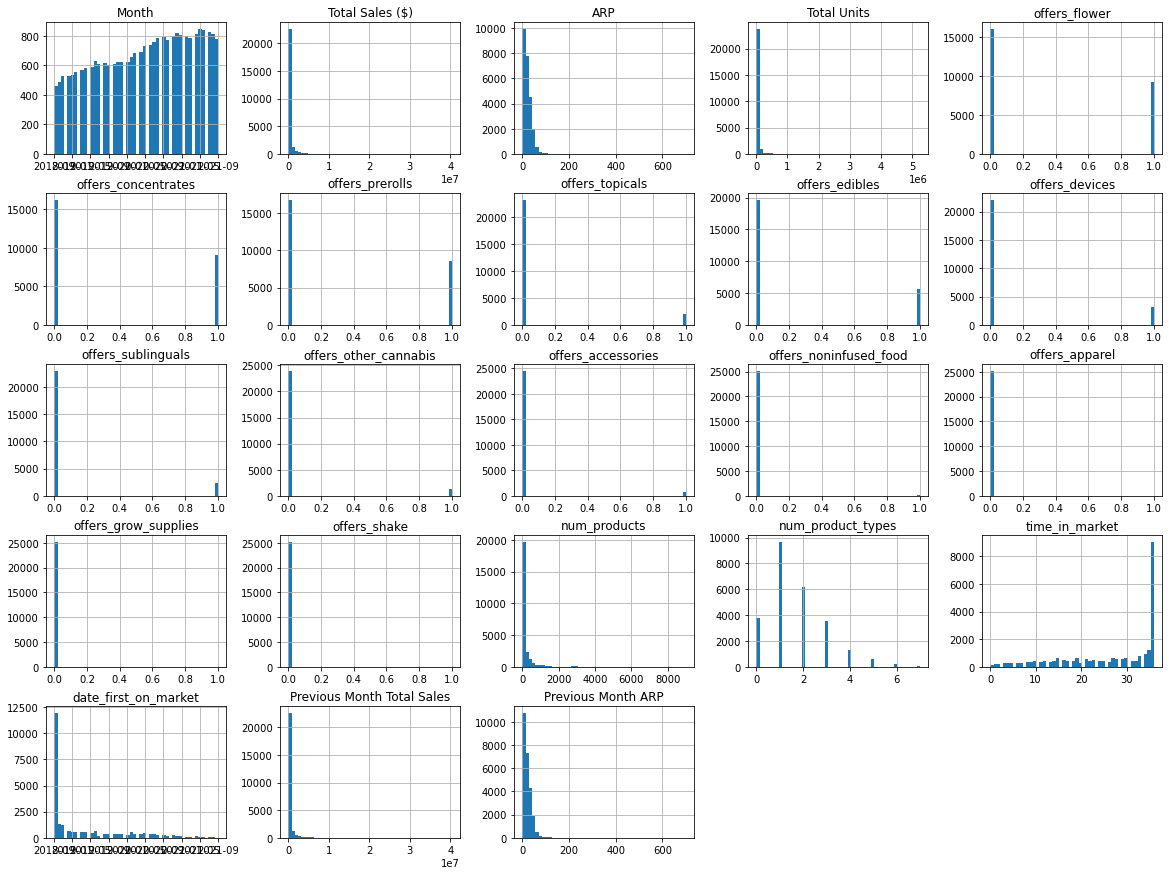

In [49]:
df.hist(bins=50, figsize=(20,15))
plt.show()

<AxesSubplot:>

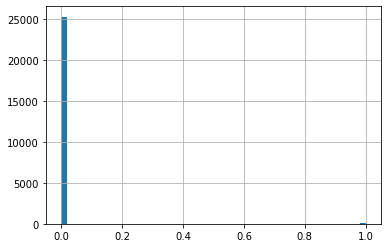

In [50]:
#based on the histograms, we might want to drop some of these offers columns, some are 25,000 zeroes, maybe we should explore
#further here 
df['offers_grow_supplies'].hist(bins=50)

,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,offers_devices,offers_sublinguals,...,offers_accessories,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,time_in_market,Previous Month Total Sales,Previous Month ARP
Total Sales ($),1.000000,-0.011378,0.875595,0.088232,0.124388,0.073648,0.059993,0.094386,0.161188,0.071517,...,-0.025345,0.023057,0.031529,0.031529,0.004773,0.500699,0.231575,0.177975,0.974939,-0.000652
ARP,-0.011378,1.000000,-0.076604,-0.292317,0.116308,-0.176309,0.228659,-0.005285,0.114742,0.194397,...,-0.060217,-0.033229,-0.034277,-0.034277,-0.037836,0.090417,-0.004317,0.020756,-0.011134,0.851365
Total Units,0.875595,-0.076604,1.000000,0.122133,0.034118,0.066221,-0.010908,0.017009,0.033053,-0.002352,...,-0.002563,0.055176,0.078261,0.078261,0.039159,0.204296,0.113903,0.118266,0.855775,-0.066236
offers_flower,0.088232,-0.292317,0.122133,1.000000,0.175128,0.523370,-0.147283,-0.196778,-0.068451,-0.107905,...,-0.110783,-0.041108,-0.029046,-0.029046,-0.029046,0.086862,0.485110,0.148876,0.086134,-0.264887
offers_concentrates,0.124388,0.116308,0.034118,0.175128,1.000000,0.227882,-0.067452,-0.052501,0.196137,0.060776,...,-0.089885,-0.040364,-0.028521,-0.028521,-0.028521,0.318838,0.559206,0.233186,0.122264,0.122610
offers_prerolls,0.073648,-0.176309,0.066221,0.523370,0.227882,1.000000,-0.134757,-0.115380,-0.029913,-0.103694,...,-0.083674,-0.038554,-0.027242,-0.027242,-0.027242,0.150352,0.544727,0.211920,0.071547,-0.153129
offers_topicals,0.059993,0.228659,-0.010908,-0.147283,-0.067452,-0.134757,1.000000,0.098570,-0.035145,0.449270,...,-0.050028,-0.015923,-0.011251,-0.011251,-0.011251,0.159738,0.227663,0.181585,0.060075,0.230340
offers_edibles,0.094386,-0.005285,0.017009,-0.196778,-0.052501,-0.115380,0.098570,1.000000,-0.011230,0.241442,...,-0.069406,0.036407,-0.020403,-0.020403,-0.020403,0.122389,0.272630,0.164755,0.092777,0.009321
offers_devices,0.161188,0.114742,0.033053,-0.068451,0.196137,-0.029913,-0.035145,-0.011230,1.000000,0.042298,...,0.230362,0.061155,0.100945,0.100945,-0.014523,0.322209,0.340738,0.223744,0.159050,0.120323
offers_sublinguals,0.071517,0.194397,-0.002352,-0.107905,0.060776,-0.103694,0.449270,0.241442,0.042298,1.000000,...,-0.023462,0.076635,-0.012169,-0.012169,-0.012169,0.127879,0.390633,0.205711,0.071364,0.198948


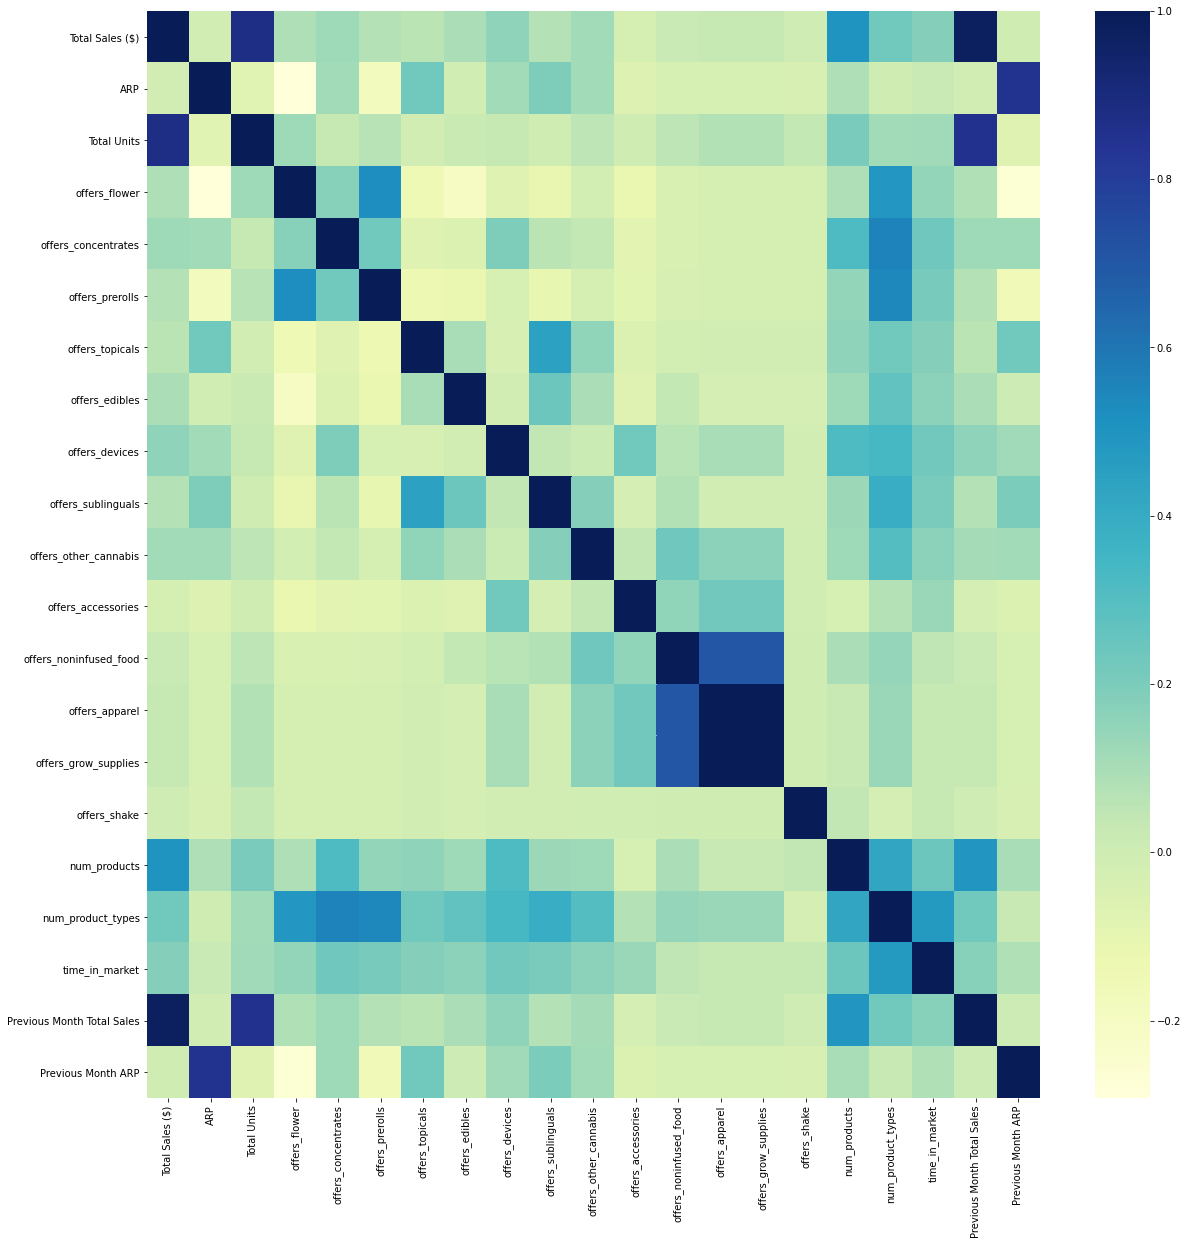

In [51]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap="YlGnBu")
df.corr()

In [52]:
#initial thoughts on correlation matrix
#lots of things are obviously correlated (total sales / total units)
#more interesting ones:
#num_products / total sales
#num_product_types / offers_concentrates - companies that offer concentrates will have more types of products
# uh oh, not too much else, should we think about adding more features?

#in terms of pipelining -
# we just need to scale
# because we already imputed all missing values (removed them)
# manually 1 hot encoded the categories (L1...L3)



### Visualizing

['Boomba' 'Boundless Technology' 'Boveda' 'Box' 'Branded' 'Brass Knuckles'
 'Breez' 'Brite Labs' "Brother David's" 'Brotherly Love Organics']


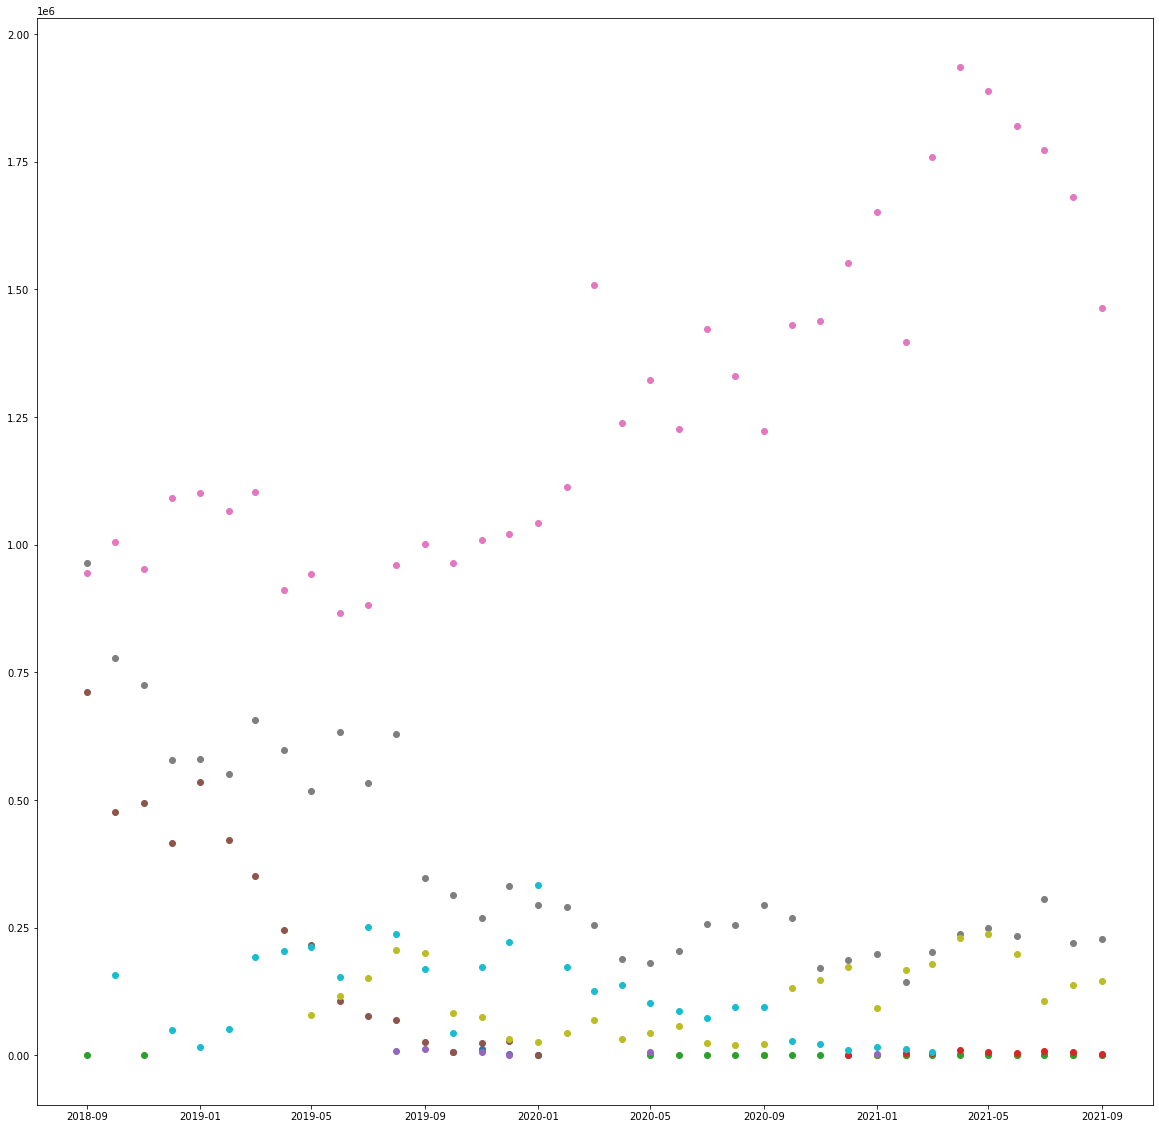

In [53]:
# lets do some scatter plots
#ill scatter plot some random companies first 
#we will look at the
# print(df['Brand'].unique())
n = 150
brands = df['Brand'].unique()[n:n + 10]
print(brands)
plt.figure(figsize=(20,20))
for brand in brands:
    brandDf = df.loc[df["Brand"] == brand]
    plt.plot_date(brandDf['Month'], brandDf['Total Sales ($)'])

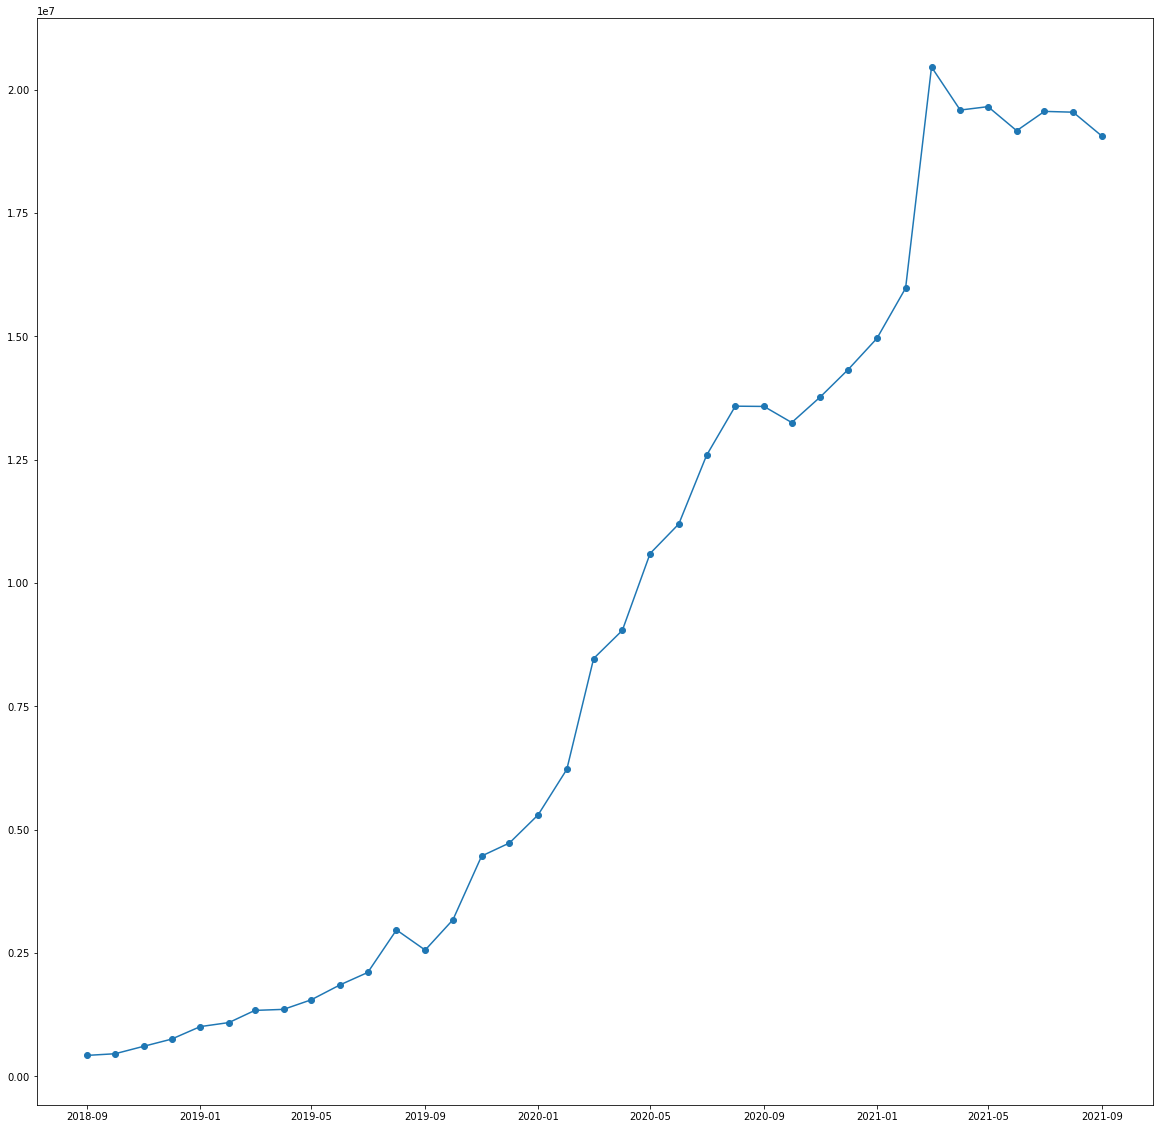

In [173]:
#make scatter based on brand name
brandDf = df.loc[df['Brand'] == "Stiiizy"]
n = 150
plt.figure(figsize=(20,20))
plt.plot_date(brandDf['Month'], brandDf['Total Sales ($)'], linestyle='solid')

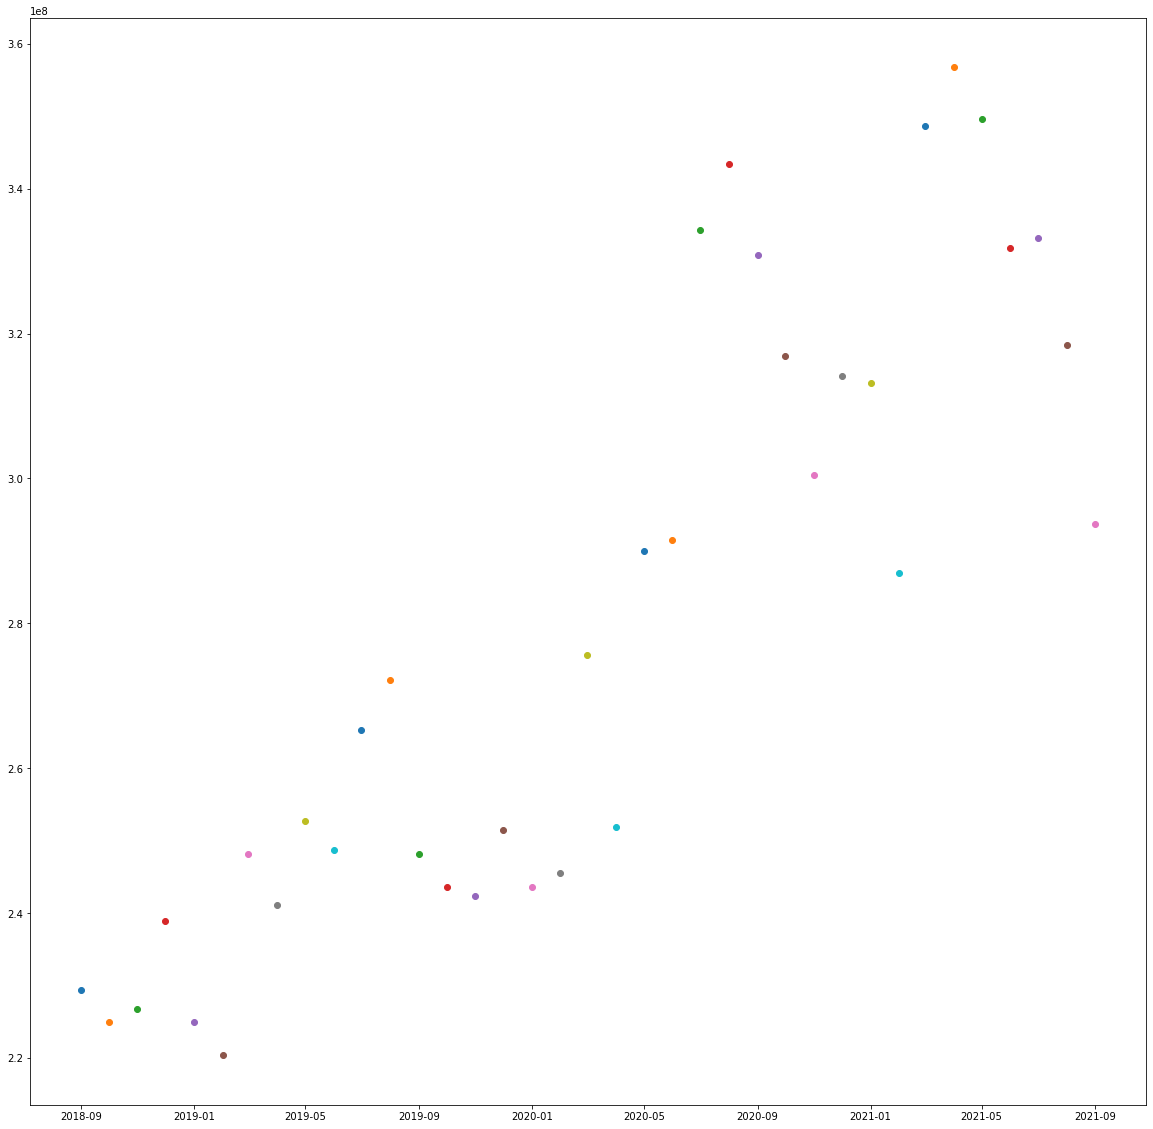

In [55]:
#sum up all sales across all brands per month
months = df['Month'].unique()

months = sorted(months)

plt.figure(figsize=(20,20))
px = 0
py = 0
for month in months:
    monthDf = df.loc[df['Month'] == month]
    plt.plot_date(month, monthDf['Total Sales ($)'].sum(axis=0))

#plt.plot_date(months, )
plt.show()

In [56]:
df_final = df.sort_values(["Month", "Brand"]).reset_index(drop=True)
df_final

,Brand,Month,Total Sales ($),ARP,Total Units,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,...,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,time_in_market,date_first_on_market,Previous Month Total Sales,Previous Month ARP
0,10x Infused,2018-09-01,1711.334232,11.980833,142.839336,0,0,0,0,0,...,0,0,0,0,0,0,0,2018-09-01,0.000000,0.000000
1,1964 Supply Co.,2018-09-01,25475.215945,10.634459,2395.534726,0,0,0,0,0,...,0,0,0,0,0,0,7,2018-09-01,0.000000,0.000000
2,3 Bros Grow,2018-09-01,120153.644757,11.992592,10018.989140,0,0,1,0,0,...,0,0,0,0,4,1,28,2018-09-01,0.000000,0.000000
3,3 Leaf,2018-09-01,6063.529785,5.507027,1101.053215,0,0,0,0,0,...,0,0,0,0,0,0,19,2018-09-01,0.000000,0.000000
4,350 Fire,2018-09-01,631510.048155,9.847509,64128.910286,0,0,0,0,0,...,0,0,0,0,0,0,15,2018-09-01,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25271,Zanna,2021-09-01,3681.159375,8.069769,456.166632,1,0,0,0,0,...,0,0,0,0,2,1,0,2021-09-01,0.000000,0.000000
25272,Zendo Edibles,2021-09-01,11508.213813,15.983929,719.986537,0,0,0,0,1,...,0,0,0,0,61,2,36,2018-09-01,15018.968584,16.143421
25273,Zig Zag,2021-09-01,18077.309311,2.702687,6688.643227,0,0,0,0,0,...,0,0,0,0,11,2,36,2018-09-01,22290.442882,2.717809
25274,Zips Weed Co.,2021-09-01,3811.072510,18.129399,210.215046,0,1,0,0,0,...,0,0,0,0,23,1,14,2020-07-01,3477.729332,17.946957


In [57]:
df_final.loc[df_final['time_in_market'] == max(df_final['time_in_market'])]['Brand'].unique()
#print out the brands that have been on the market the longest

array(['710 Labs', 'A&A Craft Inc', 'AA Packaging', 'Absolute Xtracts',
       'AiroPro', 'Alien Labs', 'Alpine Vapor', 'Americanna (CA)',
       'Amplified', 'Apex Solutions', 'ApotheCanna', 'Arcturus Cannabis',
       'Artisan Canna Cigars', 'Atlas Edibles', 'Autumn Brands',
       'Bear Labs', 'Bee Line Hemp Wick', 'Beezle Extract & Creamery ',
       'Bhang', 'Bic', "Big Pete's Treats", 'Bird Valley Organics',
       'Biscotti', 'Blank Bar', 'Blessed Extracts', 'Bloom Farms',
       'Blue River Extracts', 'Boveda', 'Breez', 'Brite Labs', 'CCELL',
       'CQ', 'CRU Cannabis', 'Cali Kush Farms', 'Caliva',
       'Cannatique Farms', 'Cannawrap', 'Canndescent', 'Care By Design ',
       "Carter's Aromatherapy Designs", 'Cheeba Chews',
       "Cheech's Private Stash", 'Chemistry', 'Chill', "Chong's Choice",
       'Clarified Confections', 'Clipper Lighters',
       'Coastal Sun Cannabis', 'Concentrate', 'Connected Cannabis Co.',
       'Cookies', 'Cosmic View', "Cosmo D's Outrageous Edi

In [58]:
#drop brand attribute and total units
df_numerical = df_final.drop(labels=['Brand'], axis=1)
#drop the total units column
df_numerical = df_numerical.drop('Total Units', axis=1)
df_numerical
# This is for brand dataframe
# df_final = df_final.drop('Total Units', axis=1)

,Month,Total Sales ($),ARP,offers_flower,offers_concentrates,offers_prerolls,offers_topicals,offers_edibles,offers_devices,offers_sublinguals,...,offers_noninfused_food,offers_apparel,offers_grow_supplies,offers_shake,num_products,num_product_types,time_in_market,date_first_on_market,Previous Month Total Sales,Previous Month ARP
0,2018-09-01,1711.334232,11.980833,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2018-09-01,0.000000,0.000000
1,2018-09-01,25475.215945,10.634459,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7,2018-09-01,0.000000,0.000000
2,2018-09-01,120153.644757,11.992592,0,0,1,0,0,0,0,...,0,0,0,0,4,1,28,2018-09-01,0.000000,0.000000
3,2018-09-01,6063.529785,5.507027,0,0,0,0,0,0,0,...,0,0,0,0,0,0,19,2018-09-01,0.000000,0.000000
4,2018-09-01,631510.048155,9.847509,0,0,0,0,0,0,0,...,0,0,0,0,0,0,15,2018-09-01,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25271,2021-09-01,3681.159375,8.069769,1,0,0,0,0,0,0,...,0,0,0,0,2,1,0,2021-09-01,0.000000,0.000000
25272,2021-09-01,11508.213813,15.983929,0,0,0,0,1,0,0,...,0,0,0,0,61,2,36,2018-09-01,15018.968584,16.143421
25273,2021-09-01,18077.309311,2.702687,0,0,0,0,0,1,0,...,0,0,0,0,11,2,36,2018-09-01,22290.442882,2.717809
25274,2021-09-01,3811.072510,18.129399,0,1,0,0,0,0,0,...,0,0,0,0,23,1,14,2020-07-01,3477.729332,17.946957


# Pipeline

In [59]:
#start messing around with pipeline


In [60]:
#get train / test split for specific brand

# brand_df = getBrandDataFrame(df_final, "Cookies")
# brand_df = brand_df.drop('Brand', axis=1)
# X_train, X_test, y_train, y_test = createTrainTestSplit(df_numerical, '2021-09-01')

#get train / test split for the whole numerical dataset
#predict 6 months in the future
X_train, X_test, y_train, y_test = createTrainTestSplit(df_numerical, '2021-09-01')

#convert the datetime columns to their ordinal values for the model
X_train = convertDateColumnToOrdinal('Month', X_train)
X_train = convertDateColumnToOrdinal('date_first_on_market', X_train)

X_test = convertDateColumnToOrdinal('Month', X_test)
X_test = convertDateColumnToOrdinal('date_first_on_market', X_test)

             

In [61]:
                            
# scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
pipe = Pipeline([('scaler', StandardScaler())])
X_train = pipe.fit_transform(X_train)
X_test = pipe.fit_transform(X_test)
# y_train = pipe.fit_transform(y_train)
# y_test = pipe.fit_transform(y_test)

 

# Linear Regression

In [62]:
lin = LinearRegression(normalize = True, n_jobs = -1, fit_intercept = True)
model = lin.fit(X_train, y_train)
test_predictions = model.predict(X_test)
linear_r2 = r2_score(y_true=y_test, y_pred = test_predictions)
print("R2 score for linear regression model: ", linear_r2)

R2 score for linear regression model:  0.992094014755229


In [63]:
#get train / test split for the whole numerical dataset
    #predict 6 months in the future
    # X_train, X_test, y_train, y_test = createTrainTestSplit(df_numerical, '2021-09-01')

    #convert the datetime columns to their ordinal values for the model

#     X_train = convertDateColumnToOrdinal('Month', X_train)
#     X_train = convertDateColumnToOrdinal('date_first_on_market', X_train)

#     X_test = convertDateColumnToOrdinal('Month', X_test)
#     X_test = convertDateColumnToOrdinal('date_first_on_market', X_test)
    

# PCA

In [64]:
# Used this as reference https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

pca = PCA(.81)

pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform (X_test)

print("Number of principal components: ", pca.n_components_)
pca.explained_variance_ratio_

Number of principal components:  11


array([0.16117544, 0.12821453, 0.1215884 , 0.0812836 , 0.06991297,
       0.0614714 , 0.05265816, 0.04728989, 0.04357661, 0.04067233,
       0.03608014])

### Visualize PCA data

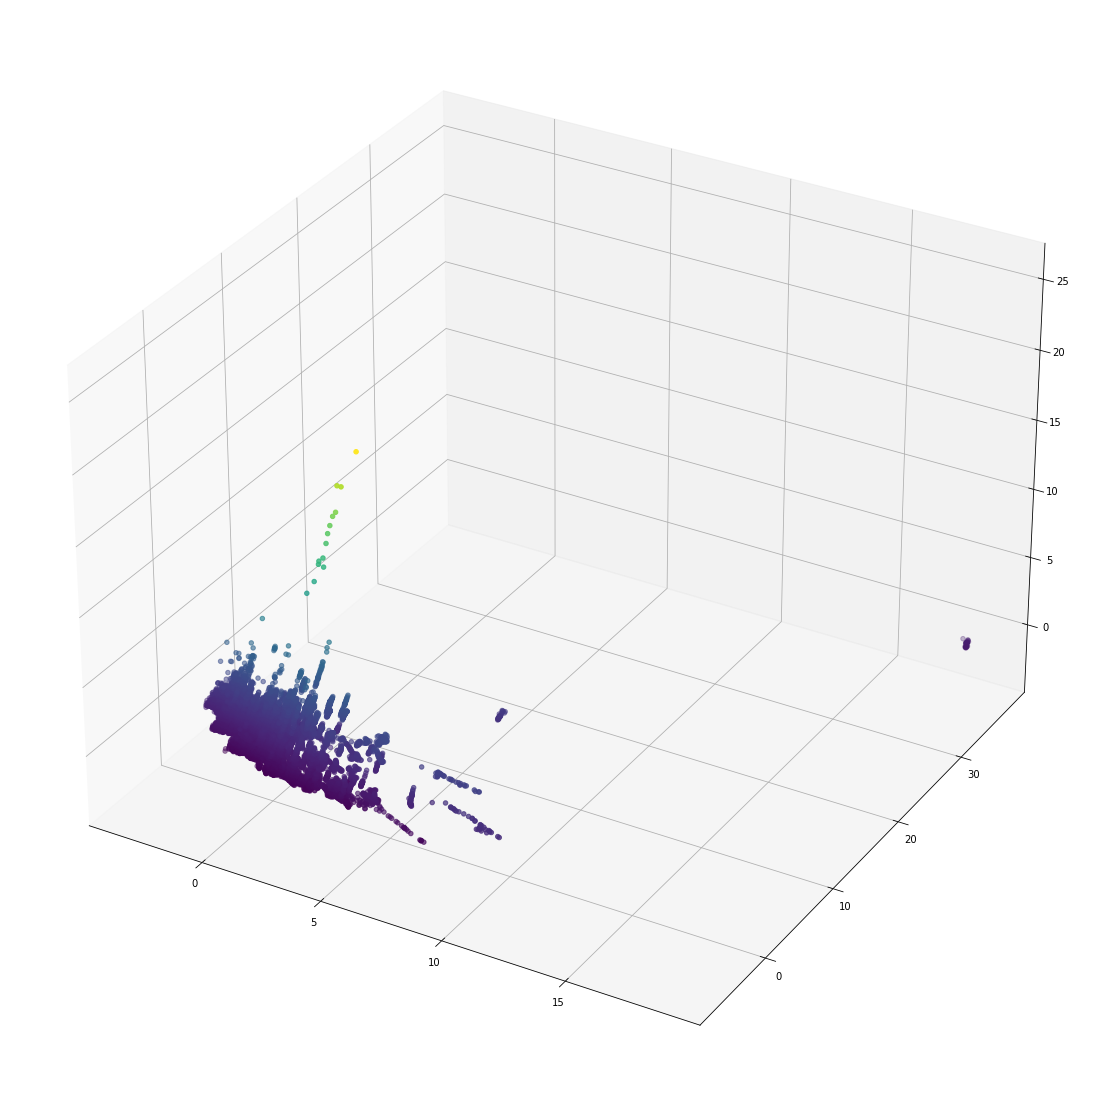

In [65]:
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')


ax.scatter3D(X_train_pca[:,0], X_train_pca[:,1], X_train_pca[:,2], c=X_train_pca[:,2])

# plt.scatter(X_train_pca[:, 0], X_train[:, 1], alpha=0.2)
# for length, vector in zip(pca.explained_variance_, pca.components_):
#     v = vector * 3 * np.sqrt(length)
#     draw_vector(pca.mean_, pca.mean_ + v)
# plt.axis('equal');

#### How much information can be attributed to each component?

In [66]:
# Here we can see how much of the variance each PCA feature captures
pca.explained_variance_ratio_

array([0.16117544, 0.12821453, 0.1215884 , 0.0812836 , 0.06991297,
       0.0614714 , 0.05265816, 0.04728989, 0.04357661, 0.04067233,
       0.03608014])

# Ensemble Method: Bagging with Random Forest on PCA'd dataframe

#### Secure the bagg
#### We chose to go with bagging because we suspected we have some overfitting

In [67]:
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Instaitiate model with 10 decision trees
rf = RandomForestRegressor(
    n_estimators = 42, 
    random_state = 148, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    max_features = 'sqrt', 
    max_depth = 50, 
    bootstrap = False
)



In [68]:
# This is slow af rip
rf.fit(X_train_pca, y_train)

RandomForestRegressor(bootstrap=False, max_depth=50, max_features='sqrt',
                      n_estimators=42, random_state=148)

In [69]:
predictions = rf.predict(X_test_pca)

In [70]:
result_mse = mse(predictions, y_test)
result_mae = mae(predictions, y_test)
result_r2 = r2_score(y_true = y_test,y_pred = predictions)
print("Random Forest | Mean Squared Error: ", result_mse)
print("Random Forest | Mean Absolute Error: ", result_mae)
print("Random Forest | R2 Score: ", result_r2)

Random Forest | Mean Squared Error:  78672014631.37291
Random Forest | Mean Absolute Error:  137198.43251572258
Random Forest | R2 Score:  0.9650492784655866


# Cross validate results

### Cross Validate Random Forest

In [71]:
# https://towardsdatascience.com/complete-guide-to-pythons-cross-validation-with-examples-a9676b5cac12

for i, score in enumerate(cross_validate(rf, X_test_pca,y_test, cv=5, scoring="r2")["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: 0.8017895983939097
Accuracy for the fold no. 1 on the test set: 0.897964802217112
Accuracy for the fold no. 2 on the test set: 0.5977818627589788
Accuracy for the fold no. 3 on the test set: 0.8201819207935526
Accuracy for the fold no. 4 on the test set: 0.6884997897179838


### Cross validating Linear Regression

In [72]:
for i, score in enumerate(cross_validate(lin, X_test,y_test, cv=5, scoring="r2")["test_score"]):
    print(f"Accuracy for the fold no. {i} on the test set: {score}")

Accuracy for the fold no. 0 on the test set: -495.96162629663434
Accuracy for the fold no. 1 on the test set: 0.9921145578239252
Accuracy for the fold no. 2 on the test set: -3.246597999647987e+24
Accuracy for the fold no. 3 on the test set: 0.9909530157795073
Accuracy for the fold no. 4 on the test set: -1.7348036366622536e+25


# Random Search Hyperparameter Optimization

#### Instead of going with Grid Search Hyperparameter optimization, we used RandomizedSearch Hyperparameter Optimizationb

### Random Forest Hyperparameter Optimization

In [73]:
# https://www.section.io/engineering-education/random-search-hyperparameters/
# Defining search space for optimizing random forest

#The possible hyperparameters for random forest
n_estimators = [int(x) for x in np.linspace(start=1, stop = 50, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

# Instance of randomized search
rf_random = RandomizedSearchCV(
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=2, 
    random_state=35, 
    n_jobs = -1
)

In [74]:
rf_random.fit(X_train_pca, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(bootstrap=False,
                                                   max_depth=50,
                                                   max_features='sqrt',
                                                   n_estimators=42,
                                                   random_state=148),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
        

#### Print best parameters for Random Forest

In [75]:
print("Best Parameters for Random Forest: ", rf_random.best_params_)

# result:
#     Best Parameters:  {
#         'n_estimators': 42, 
#         'min_samples_split': 2, 
#         'min_samples_leaf': 1, 
#         'max_features': 'sqrt', 
#         'max_depth': 50, 
#         'bootstrap': False
#     }
# Best Parameters :  {
#     'n_estimators': 30, 
#     'min_samples_split': 10, 
#     'min_samples_leaf': 3, 
#     'max_features': 'sqrt', 
#     'max_depth': 30, 
#     'bootstrap': False
# }

Best Parameters for Random Forest:  {'n_estimators': 31, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': True}


### Linear Regression Hyperparameter Optimization

In [76]:
# The possible hyperparameters for linear regression
fit_intercept = [True, False]
normalize = [True, False]
n_jobs = [-1]
positive = [True, False]


linear_random_grid= {
    'fit_intercept': fit_intercept,
    'normalize': normalize
}

lin_random = RandomizedSearchCV(estimator=lin, param_distributions = linear_random_grid, n_iter = 50, cv = 5, verbose = 2, random_state = 148, n_jobs = -1)

In [77]:
lin_random.fit(X_train_pca, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\anthony\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 4 is smaller than n_iter=50. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=LinearRegression(n_jobs=-1, normalize=True),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'fit_intercept': [True, False],
                                        'normalize': [True, False]},
                   random_state=148, verbose=2)

#### Print best parameters for Linear Regression

In [78]:
print("Best Parameters: ", lin_random.best_params_)
# Output: Best Parameters:  {'normalize': True, 'fit_intercept': True}

Best Parameters:  {'normalize': True, 'fit_intercept': True}


# Custom Model

### Custom model #1

#### High level idea: Do a linear regression for each month until we run out of months for that brand, plot each predicted point

In [79]:
#do a linear regression for each month until we run out of months for that brand, plot each predicted point
#pass in df_final
# df_final = df_final.drop('Total Units', axis=1)

415787.30993563874

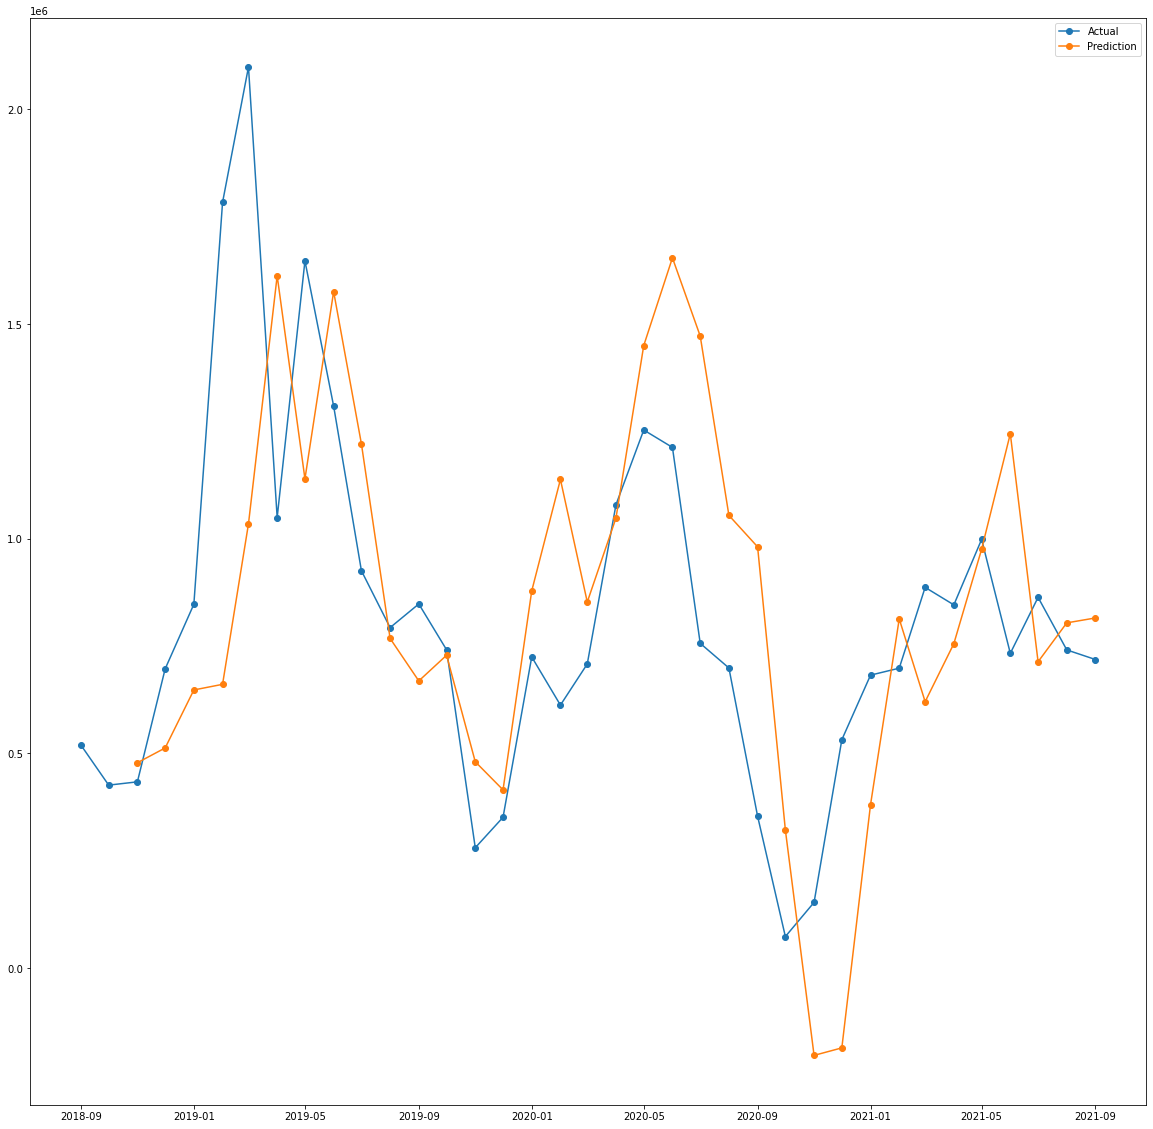

In [184]:

brand = "Cookies"
plotIterLinearRegression(df_final, brand, pca_flag=True)

#now do it over all the brands that have been on the market the whole time
#get the rmse 

#do linear regression in a walk forward fashion
pred = iterLinearRegression(df_final, brand, pca_flag=True)

brandDf = getBrandDataFrame(df_final, brand)

rmse = mse(pred, brandDf.iloc[2:]["Total Sales ($)"], squared=False)    
    
rmse




### Custom model #2

#### Linear regression with PCA

In [81]:
lin = LinearRegression(normalize = True, n_jobs = -1, fit_intercept = True)
model = lin.fit(X_train_pca, y_train)
test_predictions_pca = model.predict(X_test_pca)
linear_r2_pca = r2_score(y_true=y_test, y_pred = test_predictions_pca)
print("R2 score for linear regression model w/ PCA: ", linear_r2_pca)

R2 score for linear regression model w/ PCA:  0.8119517896687546


### CUSTOM MODEL #3

### Autorregresive Integrated Moving Average

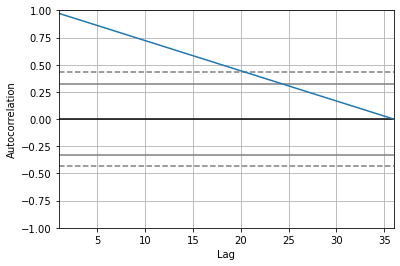

In [161]:
#arima
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA

#do it by brand?

#SELECT WHICH BRAND TO DO ARIMA ON ------
df_brand_final = getBrandDataFrame(df_final, "Korova")


df_numerical = df_brand_final.drop(labels=['Brand'], axis=1)
#drop the total units column
df_numerical = df_numerical.drop('Total Units', axis=1)

#get data again from df_numerical, this time try doing arima without all of the offers
df_numerical_without_offers = df_numerical.drop(labels = ['offers_flower', 'offers_concentrates', 'offers_prerolls', 'offers_topicals', 'offers_edibles', 'offers_devices', 'offers_sublinguals', 'offers_other_cannabis', 'offers_accessories', 'offers_noninfused_food', 'offers_apparel', 'offers_grow_supplies', 'offers_shake'], axis=1)

# df_numerical_without_offers = convertDateColumnToOrdinal('Month', df_numerical_without_offers)
# df_numerical_without_offers = convertDateColumnToOrdinal('date_first_on_market', df_numerical_without_offers)


# #do standard scaling
#create train and test split
X_train, X_test, y_train, y_test = createTrainTestSplit(df_numerical_without_offers, '2021-09-01')


df_numerical_without_offers.describe()
#convert the datetime columns to their ordinal values for the model
X_train = convertDateColumnToOrdinal('Month', X_train)
X_train = convertDateColumnToOrdinal('date_first_on_market', X_train)
X_test = convertDateColumnToOrdinal('Month', X_test)
X_test = convertDateColumnToOrdinal('date_first_on_market', X_test)

# X_train

# #plotting the autocorrelation vs lag without standardScaling

ax = autocorrelation_plot(X_train)
# ax.set_xlim([0, 500])
#the autocorrelation is perfectly linear? explain why 
plt.show()


#running into issue with standardized data, cant select month in createTrainTestSplit after the data is n


Number of principal components:  11
[0.16117544 0.12821453 0.1215884  0.0812836  0.06991297 0.0614714
 0.05265816 0.04728989 0.04357661 0.04067233 0.03608014]


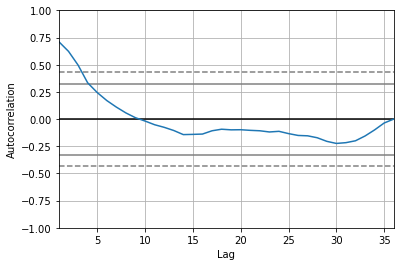

In [162]:
#try with pca 
# Used this as reference https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
#run pipeline on data to do standardscaling
pipe = Pipeline([('scaler', StandardScaler())])
X_train = pipe.fit_transform(X_train)
X_test = pipe.fit_transform(X_test)

#for doing the whole dataframe, need to make dates ordinal first
pca_arima = PCA(.81)

pca_arima.fit(X_train)

X_train_pca = pca_arima.transform(X_train)
# X_test_pca = pca_arima.transform(X_test)

print("Number of principal components: ", pca.n_components_)
print(pca.explained_variance_ratio_)

ax = autocorrelation_plot(X_train_pca)
plt.show()

#after doing PCA, the line looks much better
#

In [163]:
# fit model
model = ARIMA(endog=y_train, exog=X_train, order=(5,1,0))
model_fit = model.fit()
# summary of fit model


print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:        Total Sales ($)   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -485.471
Date:                Sat, 04 Dec 2021   AIC                            998.942
Time:                        16:50:26   BIC                           1020.717
Sample:                             0   HQIC                          1006.459
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -8.349e+05   4.64e+05     -1.799      0.072   -1.74e+06    7.49e+04
x2         -6.496e+04   7.49e+04     -0.868      0.386   -2.12e+05    8.18e+04
const               0   5.69e+05          0      1.0

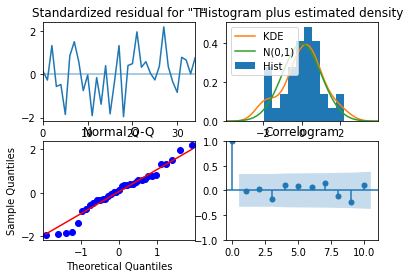

In [116]:
model_fit.plot_diagnostics()
plt.show()
# Produces a 2x2 plot grid with the following plots (ordered clockwise from top left):

# Standardized residuals over time

# Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.

# Normal Q-Q plot, with Normal reference line.

# Correlogram

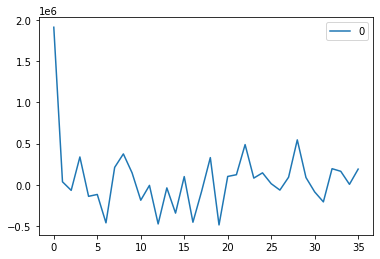

In [119]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

#plotting residuals shows that error is approaching 0 fairly quickly
#promising for arima
#stationary vs non stationary data?

In [164]:
res = model_fit.forecast(exog=X_test)
err = y_test.iloc[0] - res

print(err)
print("percent error for 1 month initial prediction: ", err / y_test.iloc[0] )

36   -890227.442109
dtype: float64
percent error for 1 month initial prediction:  36   -0.854569
dtype: float64


In [167]:
#now that we know ARIMA is doing something, try to find best params for highest log likelihood
#looking for best fit
#grid search?

# grid = {
#     'p': ar,
#     'd': i,
#     'q': ma,
# }

max_log_likelihood = None
optimal_order = (None, None, None)
#cant use scikit with ARIMA, write custom GridSearch
for p in range(1, 5):
    for d in range(1, 5):
         for q in range(1, 5):
            q = 1
            model = ARIMA(endog=y_train, exog=X_train, order=(p,d,q))
            model_fit = model.fit()
            
            if max_log_likelihood == None or model_fit.llf > max_log_likelihood:
                max_log_likelihood = model_fit.llf
                optimal_order = (p, d, q)
                optimal_model = model_fit
                





C:\Users\anthony\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\anthony\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\anthony\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\anthony\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\anthony\anaconda3\lib\site-packages\statsmodels\

In [171]:

print(optimal_model.summary(), optimal_order, max_log_likelihood)
#make forecast and save the model with the best 1 month forecast (september 2021)
res = optimal_model.forecast(exog=X_train[-1])
err = y_train.iloc[-1] - res

print(err)
print("percent error for 1 month initial prediction: ", (err / y_test.iloc[0]) % 100 )
            

#hyperparameter tuning on ARIMA


                               SARIMAX Results                                
Dep. Variable:        Total Sales ($)   No. Observations:                   36
Model:                 ARIMA(4, 4, 1)   Log Likelihood                -463.708
Date:                Sat, 04 Dec 2021   AIC                            955.416
Time:                        16:55:50   BIC                            975.936
Sample:                             0   HQIC                           962.218
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -3.755e+07   1971.126  -1.91e+04      0.000   -3.76e+07   -3.76e+07
x2          7.792e+04   1.49e+05      0.523      0.601   -2.14e+05     3.7e+05
const      -5.365e-11   4525.398  -1.19e-14      1.0

In [ ]:
#after doing hyperparameter tuning, we achived a best maximum log likelihood of -463, and our percent error is 96%, not good. 